# Creating Table of features from datas

In [1]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

## Imprting datasets
For the dataset we will use
- ibd_userfile_new_production
- ec_He_old_production.root
- rec_Li_old_production.root
- rec_Th_old_production.root
- rec_U_old_production.root

for the background.

In [38]:
file_BKG_He = up.open("../../../../mnt/data/userfiles/rec_He_old_production.root")
file_BKG_Li = up.open("../../../../mnt/data/userfiles/rec_Li_old_production.root")
file_BKG_Th = up.open("../../../../mnt/data/userfiles/rec_Th_old_production.root")
file_BKG_U = up.open("../../../../mnt/data/userfiles/rec_U_old_production.root")

file_IBD = up.open('../../../../mnt/data/userfiles/ibd_userfile_new_production.root')


dataset_IBD_all = file_IBD['TRec'].arrays(library = 'np')

dataset_BKG_He_all = file_BKG_He['TRec'].arrays(library = 'np')
dataset_BKG_Li_all = file_BKG_Li['TRec'].arrays(library = 'np')
dataset_BKG_Th_all = file_BKG_Th['TRec'].arrays(library = 'np')
dataset_BKG_U_all = file_BKG_U['TRec'].arrays(library = 'np')


dataset_IBD = {}
dataset_BKG_He = {}
dataset_BKG_Li = {}
dataset_BKG_Th = {}
dataset_BKG_U = {}

for key in ['recx', 'recy', 'recz', 'm_QEn', 'timestamp', 'SimID']:
    dataset_IBD[key] = dataset_IBD_all[key]

for key in ['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT']:
    dataset_BKG_He[key] = dataset_BKG_He_all[key]
    dataset_BKG_Li[key] = dataset_BKG_Li_all[key]
    dataset_BKG_Th[key] = dataset_BKG_Th_all[key]
    dataset_BKG_U[key] = dataset_BKG_U_all[key]
    

#Adding SimID to the BKG dataset
dataset_BKG_He["SimID"] = np.arange(len(dataset_BKG_He["m_QEn"]))
dataset_BKG_Li["SimID"] = np.arange(len(dataset_BKG_Li["m_QEn"]))
dataset_BKG_Th["SimID"] = np.arange(len(dataset_BKG_Th["m_QEn"]))
dataset_BKG_U["SimID"] = np.arange(len(dataset_BKG_U["m_QEn"]))

#Energy factor
E_factor = 0.92 

dataset_BKG_He["m_QEn"] = dataset_BKG_He["m_QEn"]*E_factor
dataset_BKG_Li["m_QEn"] = dataset_BKG_Li["m_QEn"]*E_factor
dataset_BKG_Th["m_QEn"] = dataset_BKG_Th["m_QEn"]*E_factor
dataset_BKG_U["m_QEn"] = dataset_BKG_U["m_QEn"]*E_factor


In [44]:
dataset_BKG_He_all.keys()

dict_keys(['recx', 'recy', 'recz', 'recQx', 'recQy', 'recQz', 'recTx', 'recTy', 'recTz', 'recQTx', 'recQTy', 'recQTz', 'recQTt0', 'timeRecx', 'timeRecy', 'timeRecz', 'timeRecE', 'timeRect0', 'm_QR', 'm_TR', 'm_QTR', 'm_NQE', 'm_QEn', 'm_QTEn', 'm_PESum', 'm_Qstat', 'm_Tstat', 'm_QTstat', 'm_QL', 'm_TL', 'm_QTL', 'm_QRerr', 'm_TRerr', 'm_QTRerr', 'm_triggerT', 'm_dTriggerT', 'm_FadcEvtT', 'm_Qtime', 'm_Ttime', 'm_QTtime', 'm_memory', 'Truex', 'Truey', 'Truez', 'TrueQx', 'TrueQy', 'TrueQz', 'TrueR', 'TrueQR', 'edep'])

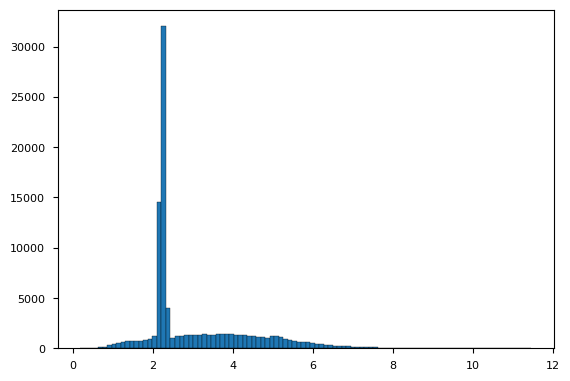

In [39]:
plt.hist(dataset_BKG_He['m_QEn'], bins = 100,label = 'He');

In [33]:
dataset_BKG_He["SimID"]
# dataset_IBD_all["EventID"]

array([    0,     1,     2, ..., 99242, 99243, 99244])

In [9]:
print(dataset_BKG_He.keys())
print(dataset_BKG_Li.keys())
print(dataset_BKG_Th.keys())
print(dataset_BKG_U.keys())


dict_keys(['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT', 'SimID'])
dict_keys(['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT', 'SimID'])
dict_keys(['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT', 'SimID'])
dict_keys(['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT', 'SimID'])


In [10]:
print("IBD events: ", len(dataset_IBD["m_QEn"]))
print("BKG events He: ", len(dataset_BKG_He["m_QEn"]))
print("BKG events Li: ", len(dataset_BKG_Li["m_QEn"]))
print("BKG events Th: ", len(dataset_BKG_Th["m_QEn"]))
print("BKG events U: ", len(dataset_BKG_U["m_QEn"]))

IBD events:  2977856
BKG events He:  99245
BKG events Li:  99242
BKG events Th:  93336
BKG events U:  87372


## Creation of two tables of features
One for IBD events and one for BKG, keeping them separately.


The feature table will have those features ($\Delta t$, $\Delta r$, $E_p$, $E_d$,$R_{prompt}$, $R_{delayed}$, $Label$)

In [11]:
from numba import njit, prange

In [12]:
@njit(parallel = True)
def create_features_handle(x,y,z,E,t,SimID,expon_time_cut = 5 * 220e3):

    n = x.shape[0] - 1
      
    delta_time = n*[np.zeros(0)]
    delta_radius = n*[np.zeros(0)]
    E_pro = n*[np.zeros(0)]
    E_del = n*[np.zeros(0)] 
    R_prompt = n*[np.zeros(0)]
    R_delayed = n*[np.zeros(0)]
    Label = n*[np.zeros(0)]

    for i in prange(x.shape[0] - 1):

        mask = np.logical_and(t>t[i], (t - t[i]) < expon_time_cut)
        to_loop = np.nonzero(mask)[0] 

        for t_index in range(len(to_loop)):
            j = to_loop[t_index] 

            if (t[j] - t[i]) < expon_time_cut:
                if (j-i)<1000 and j>i: #provvisorio
                    delta_time[i] = np.append(delta_time[i], t[j] - t[i])
                    delta_radius[i] = np.append(delta_radius[i], np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
                    E_pro[i] = np.append(E_pro[i], E[i])
                    E_del[i] = np.append(E_del[i], E[j])
                    R_prompt[i] = np.append(R_prompt[i],np.sqrt((x[i])**2 + (y[i])**2 + (z[i])**2))
                    R_delayed[i] = np.append(R_delayed[i],np.sqrt((x[j])**2 + (y[j])**2 + (z[j])**2))
                    
                    if SimID[i] == SimID[j]:
                        Label[i] = np.append(Label[i], 1)
                    elif SimID[i] != SimID[j]:
                        Label[i] = np.append(Label[i], 0)

            else:
                print(i, j, t[j] - t[i], 'Qualcosa non va')
                break

    return delta_time, delta_radius, E_pro, E_del, R_prompt, R_delayed, Label

from iteration_utilities import deepflatten

# Funzione per fare un flatten dell'output di Numba
def create_features(x,y,z,E,t,SimID,expon_time_cut = 5 * 220e3):
    res = create_features_handle(x,y,z,E,t,SimID,expon_time_cut)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))  
    return out

### For IBD events

In [13]:
features_IBD = {"delta_time": np.array([]), 
            "delta_radius": np.array([]),
            "E_pro": np.array([]),
            "E_del": np.array([]),
            "R_prompt": np.array([]),
            "R_delayed": np.array([]),
            "Label": np.array([])} 


features_IBD["delta_time"],features_IBD["delta_radius"],features_IBD["E_pro"],features_IBD["E_del"],features_IBD["R_prompt"],features_IBD["R_delayed"],features_IBD['Label']  = create_features(
    dataset_IBD["recx"],
    dataset_IBD["recy"],
    dataset_IBD["recz"],
    dataset_IBD["m_QEn"],
    dataset_IBD["timestamp"],
    dataset_IBD["SimID"])




In [14]:
print(features_IBD["delta_time"].shape[0])
print(features_IBD["delta_radius"].shape[0])
print(features_IBD["E_pro"].shape[0])
print(features_IBD["E_del"].shape[0])
print(features_IBD["R_prompt"].shape[0])
print(features_IBD["R_delayed"].shape[0])
print((features_IBD["Label"].sum()/features_IBD["Label"].shape[0]) * 100)

1475009
1475009
1475009
1475009
1475009
1475009
99.55091799439867


### For the BKG events

In [15]:
features_BKG_He = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([]),
                "Label": np.array([])} 


features_BKG_He["delta_time"],features_BKG_He["delta_radius"],features_BKG_He["E_pro"],features_BKG_He["E_del"],features_BKG_He["R_prompt"],features_BKG_He["R_delayed"],features_BKG_He["Label"] = create_features(
        dataset_BKG_He["recx"],
        dataset_BKG_He["recy"],
        dataset_BKG_He["recz"],
        dataset_BKG_He["m_QEn"],
        dataset_BKG_He["m_triggerT"],
        dataset_BKG_He["SimID"])


features_BKG_Li = {"delta_time": np.array([]),
                "delta_radius": np.array([]),  
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([]),
                "Label": np.array([])}

features_BKG_Li["delta_time"],features_BKG_Li["delta_radius"],features_BKG_Li["E_pro"],features_BKG_Li["E_del"],features_BKG_Li["R_prompt"],features_BKG_Li["R_delayed"],features_BKG_Li["Label"] = create_features(
        dataset_BKG_Li["recx"],
        dataset_BKG_Li["recy"],
        dataset_BKG_Li["recz"],
        dataset_BKG_Li["m_QEn"],
        dataset_BKG_Li["m_triggerT"],
        dataset_BKG_Li["SimID"])

features_BKG_Th = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([]),
                "Label": np.array([])}

features_BKG_Th["delta_time"],features_BKG_Th["delta_radius"],features_BKG_Th["E_pro"],features_BKG_Th["E_del"],features_BKG_Th["R_prompt"],features_BKG_Th["R_delayed"],features_BKG_Th["Label"] = create_features(
        dataset_BKG_Th["recx"],
        dataset_BKG_Th["recy"],
        dataset_BKG_Th["recz"],
        dataset_BKG_Th["m_QEn"],
        dataset_BKG_Th["m_triggerT"],
        dataset_BKG_Th["SimID"])

features_BKG_U = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([]),
                "Label": np.array([])}

features_BKG_U["delta_time"],features_BKG_U["delta_radius"],features_BKG_U["E_pro"],features_BKG_U["E_del"],features_BKG_U["R_prompt"],features_BKG_U["R_delayed"],features_BKG_U["Label"] = create_features(
        dataset_BKG_U["recx"],
        dataset_BKG_U["recy"],
        dataset_BKG_U["recz"],
        dataset_BKG_U["m_QEn"],
        dataset_BKG_U["m_triggerT"],
        dataset_BKG_U["SimID"])


In [16]:
print("He --------------------")

print(features_BKG_He["delta_time"].shape[0])
print(features_BKG_He["delta_radius"].shape[0])
print(features_BKG_He["E_pro"].shape[0])
print(features_BKG_He["E_del"].shape[0])
print(features_BKG_He["R_prompt"].shape[0])
print(features_BKG_He["R_delayed"].shape[0])
print(features_BKG_He["Label"].shape[0])

print("Li --------------------")

print(features_BKG_Li["delta_time"].shape[0])
print(features_BKG_Li["delta_radius"].shape[0])
print(features_BKG_Li["E_pro"].shape[0])
print(features_BKG_Li["E_del"].shape[0])
print(features_BKG_Li["R_prompt"].shape[0])
print(features_BKG_Li["R_delayed"].shape[0])
print(features_BKG_Li["Label"].shape[0])

print("Th --------------------")

print(features_BKG_Th["delta_time"].shape[0])
print(features_BKG_Th["delta_radius"].shape[0])
print(features_BKG_Th["E_pro"].shape[0])
print(features_BKG_Th["E_del"].shape[0])
print(features_BKG_Th["R_prompt"].shape[0])
print(features_BKG_Th["R_delayed"].shape[0])
print(features_BKG_Th["Label"].shape[0])

print("U --------------------")

print(features_BKG_U["delta_time"].shape[0])
print(features_BKG_U["delta_radius"].shape[0])
print(features_BKG_U["E_pro"].shape[0])
print(features_BKG_U["E_del"].shape[0])
print(features_BKG_U["R_prompt"].shape[0])
print(features_BKG_U["R_delayed"].shape[0])
print(features_BKG_U["Label"].shape[0])

He --------------------
44916
44916
44916
44916
44916
44916
44916
Li --------------------
44872
44872
44872
44872
44872
44872
44872
Th --------------------
42284
42284
42284
42284
42284
42284
42284
U --------------------
39578
39578
39578
39578
39578
39578
39578


# Merging the IBD and BKG tables, but the tables before the cuts 

In [17]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        if k in d1 and k in d2 and isinstance(d1[k], np.ndarray) and isinstance(d2[k], np.ndarray):
            combined[k] = np.concatenate([d1[k], d2[k]])
        elif k in d1:
            combined[k] = d1[k]
        else:
            combined[k] = d2[k]
    source = np.concatenate([np.full_like(d1.get(k, []), 1), np.full_like(d2.get(k, []), 0)])
    return {**combined, 'Source': source}
    

In [18]:
all_feature_IBD_He = combine_dict(features_IBD,features_BKG_He)
all_feature_IBD_Li = combine_dict(features_IBD,features_BKG_Li)
all_feature_IBD_Th = combine_dict(features_IBD,features_BKG_Th)
all_feature_IBD_U = combine_dict(features_IBD,features_BKG_U)


### Shuffle in random order

In [19]:
# ottieni il numero di righe in ogni array
n_rows_He = all_feature_IBD_He['E_del'].shape[0]
n_rows_Li = all_feature_IBD_Li['E_del'].shape[0]
n_rows_Th = all_feature_IBD_Th['E_del'].shape[0]
n_rows_U = all_feature_IBD_U['E_del'].shape[0]


# crea un nuovo ordine casuale degli indici delle righe
new_order_He = np.random.permutation(n_rows_He)
new_order_Li = np.random.permutation(n_rows_Li)
new_order_Th = np.random.permutation(n_rows_Th)
new_order_U = np.random.permutation(n_rows_U)


# estrai le righe nei nuovi indici
for key in all_feature_IBD_He:	
    all_feature_IBD_He[key] = all_feature_IBD_He[key][new_order_He]

for key in all_feature_IBD_Li:
    all_feature_IBD_Li[key] = all_feature_IBD_Li[key][new_order_Li]

for key in all_feature_IBD_Th:
    all_feature_IBD_Th[key] = all_feature_IBD_Th[key][new_order_Th]

for key in all_feature_IBD_U:
    all_feature_IBD_U[key] = all_feature_IBD_U[key][new_order_U]


{'R_prompt': array([15918.03433752, 15641.4413821 , 16691.09268811, ...,
       17057.53766865, 11875.98927885,  9564.89281866]), 'R_delayed': array([15323.5155222 , 15466.80447927, 16768.31591134, ...,
       17044.7795973 , 12183.25980367,  9901.42847637]), 'E_pro': array([4.06578, 3.98688, 2.85297, ..., 3.40963, 3.32596, 3.28665]), 'delta_time': array([110719.,   8544.,  68176., ..., 407600.,  38112., 489056.]), 'delta_radius': array([726.43098261, 262.80531882, 253.46246764, ..., 416.45287188,
       372.22766824, 568.0908239 ]), 'Label': array([1., 1., 1., ..., 1., 1., 1.]), 'E_del': array([2.17587, 2.1962 , 2.21575, ..., 2.23898, 2.21503, 2.26038]), 'Source': array([1., 1., 1., ..., 1., 1., 1.])}


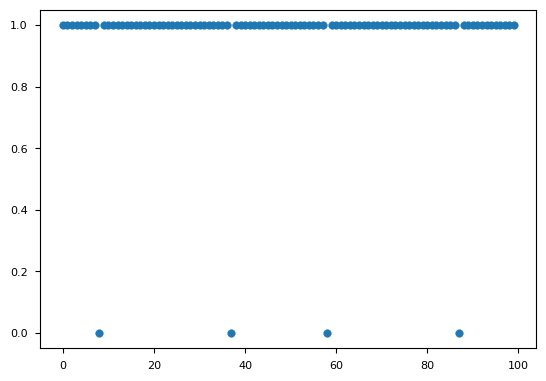

In [27]:
print(all_feature_IBD_He)

plt.scatter(np.arange(all_feature_IBD_He['Label'][:100].shape[0]), all_feature_IBD_He['Label'][:100])

# Saving data

In [29]:
print(all_feature_IBD_He.keys())

dict_keys(['R_prompt', 'R_delayed', 'E_pro', 'delta_time', 'delta_radius', 'Label', 'E_del', 'Source'])


In [30]:
np.savetxt("../../../../mnt/fcufino/all_features_IBD_He.csv", np.column_stack(list(all_feature_IBD_He.values())), delimiter=",", header=",".join(list(all_feature_IBD_He.keys())), comments="")
np.savetxt("../../../../mnt/fcufino/all_features_IBD_Li.csv", np.column_stack(list(all_feature_IBD_Li.values())), delimiter=",", header=",".join(list(all_feature_IBD_Li.keys())), comments="") 
np.savetxt("../../../../mnt/fcufino/all_features_IBD_Th.csv", np.column_stack(list(all_feature_IBD_Th.values())), delimiter=",", header=",".join(list(all_feature_IBD_Th.keys())), comments="")
np.savetxt("../../../../mnt/fcufino/all_features_IBD_U.csv", np.column_stack(list(all_feature_IBD_U.values())), delimiter=",", header=",".join(list(all_feature_IBD_U.keys())), comments="")
